<a href="https://colab.research.google.com/github/Deolinda1506/ml/blob/main/notebook/glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Glaucoma Detection - Model Training and Evaluation 




In [3]:
import sys
sys.path.append('../src')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
import json
from datetime import datetime
warnings.filterwarnings('ignore')

# Import our custom modules
from preprocessing import ImagePreprocessor
from model import GlaucomaDetectionModel
from prediction import PredictionService

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: []


2025-08-02 00:19:01.937386: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



1. DATA LOADING AND PREPROCESSING
Loading dataset...
Training set: 20 images
Test set: 10 images
Image shape: (224, 224, 3)
Classes: [0 1]

Dataset Analysis:
{
  "total_images": 20,
  "class_distribution": {
    "glaucoma": 10,
    "normal": 10
  },
  "image_sizes": [
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      224,
      224
    ],
    [
      224,
      224
    ],
    [
      224,
      224
    ],
    [
      224,
      224
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      224,
      224
    ],
    [
      224,
      224
    ],
    [
      512,
      512
    ]
  ],
  "file_formats": {
    "jpg": 14,
    "png": 

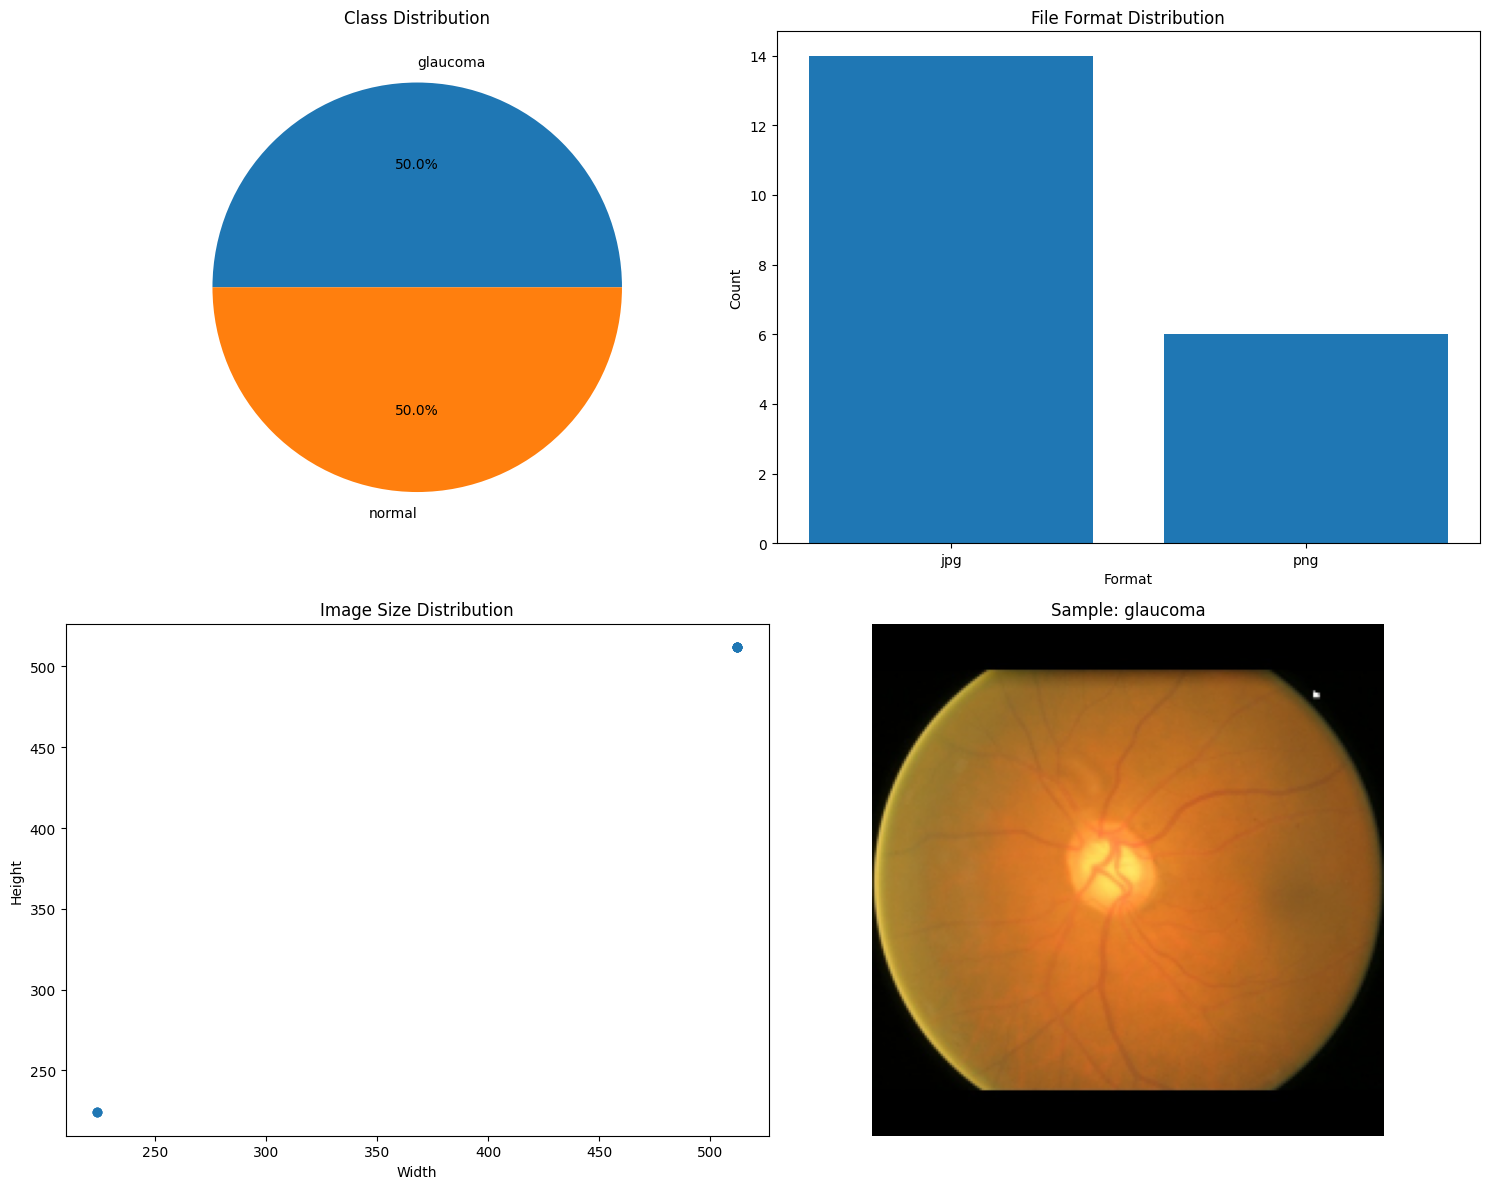


Data splits:
Training set: 16 images
Validation set: 4 images
Test set: 10 images


In [4]:
print("\n" + "="*60)
print("1. DATA LOADING AND PREPROCESSING")
print("="*60)

# Initialize preprocessor
preprocessor = ImagePreprocessor(img_size=(224, 224))

# Load dataset
print("Loading dataset...")
train_images, train_labels = preprocessor.load_dataset('../data/train')
test_images, test_labels = preprocessor.load_dataset('../data/test')

print(f"Training set: {train_images.shape[0]} images")
print(f"Test set: {test_images.shape[0]} images")
print(f"Image shape: {train_images.shape[1:]}")
print(f"Classes: {np.unique(train_labels)}")

# Analyze dataset characteristics
print("\nDataset Analysis:")
analysis = preprocessor.analyze_dataset('../data/train')
print(json.dumps(analysis, indent=2))

# Create visualizations
print("\nCreating dataset visualizations...")
os.makedirs('../static', exist_ok=True)
preprocessor.create_visualizations('../data/train', save_path='../static/dataset_analysis.png')

# Split training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_labels
)

print(f"\nData splits:")
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {test_images.shape[0]} images")


In [18]:
print("\n" + "="*60)
print("2. MODEL ARCHITECTURE AND TRAINING")
print("="*60)

# Create and compile model
model = GlaucomaDetectionModel(img_size=(224, 224), num_classes=2)
model.create_model(model_type='vgg16')
model.compile_model(learning_rate=0.0001, optimizer='adam')

# Display model summary
print("Model Architecture:")
print(model.get_model_summary())

# Create data generators with augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create generators
batch_size = 32
train_generator = train_datagen.flow(
    X_train, keras.utils.to_categorical(y_train, num_classes=2),
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, keras.utils.to_categorical(y_val, num_classes=2),
    batch_size=batch_size,
    shuffle=False
)

# Train the model
print("\nStarting model training...")
os.makedirs('../models', exist_ok=True)
history = model.train(
    train_generator, 
    val_generator,
    epochs=100,  # Reduced for faster training
    batch_size=batch_size,
    model_save_path='../models/glaucoma_model.h5'
)

print("Training completed!")



2. MODEL ARCHITECTURE AND TRAINING
Model Architecture:


Model: "sequential_6"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼───────────────────

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1875 - loss: 0.7472 - precision: 0.1875 - recall: 0.1875
Epoch 1: val_accuracy improved from None to 0.50000, saving model to ../models/glaucoma_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1875 - loss: 0.7472 - precision: 0.1875 - recall: 0.1875 - val_accuracy: 0.5000 - val_loss: 0.6933 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5625 - loss: 0.6902 - precision: 0.5625 - recall: 0.5625
Epoch 2: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.5625 - loss: 0.6902 - precision: 0.5625 - recall: 0.5625 - val_accuracy: 0.5000 - val_loss: 0.6934 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2500 - loss: 0.7540 - precision: 0.2500 - recall: 0.2500
Epoch 3: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.2500 - loss: 0.7540 - precision: 0.2500 - recall: 0.2500 - val_accuracy: 0.5000 - val_loss: 0.6934 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 1


3. MODEL EVALUATION
Creating training history visualization...


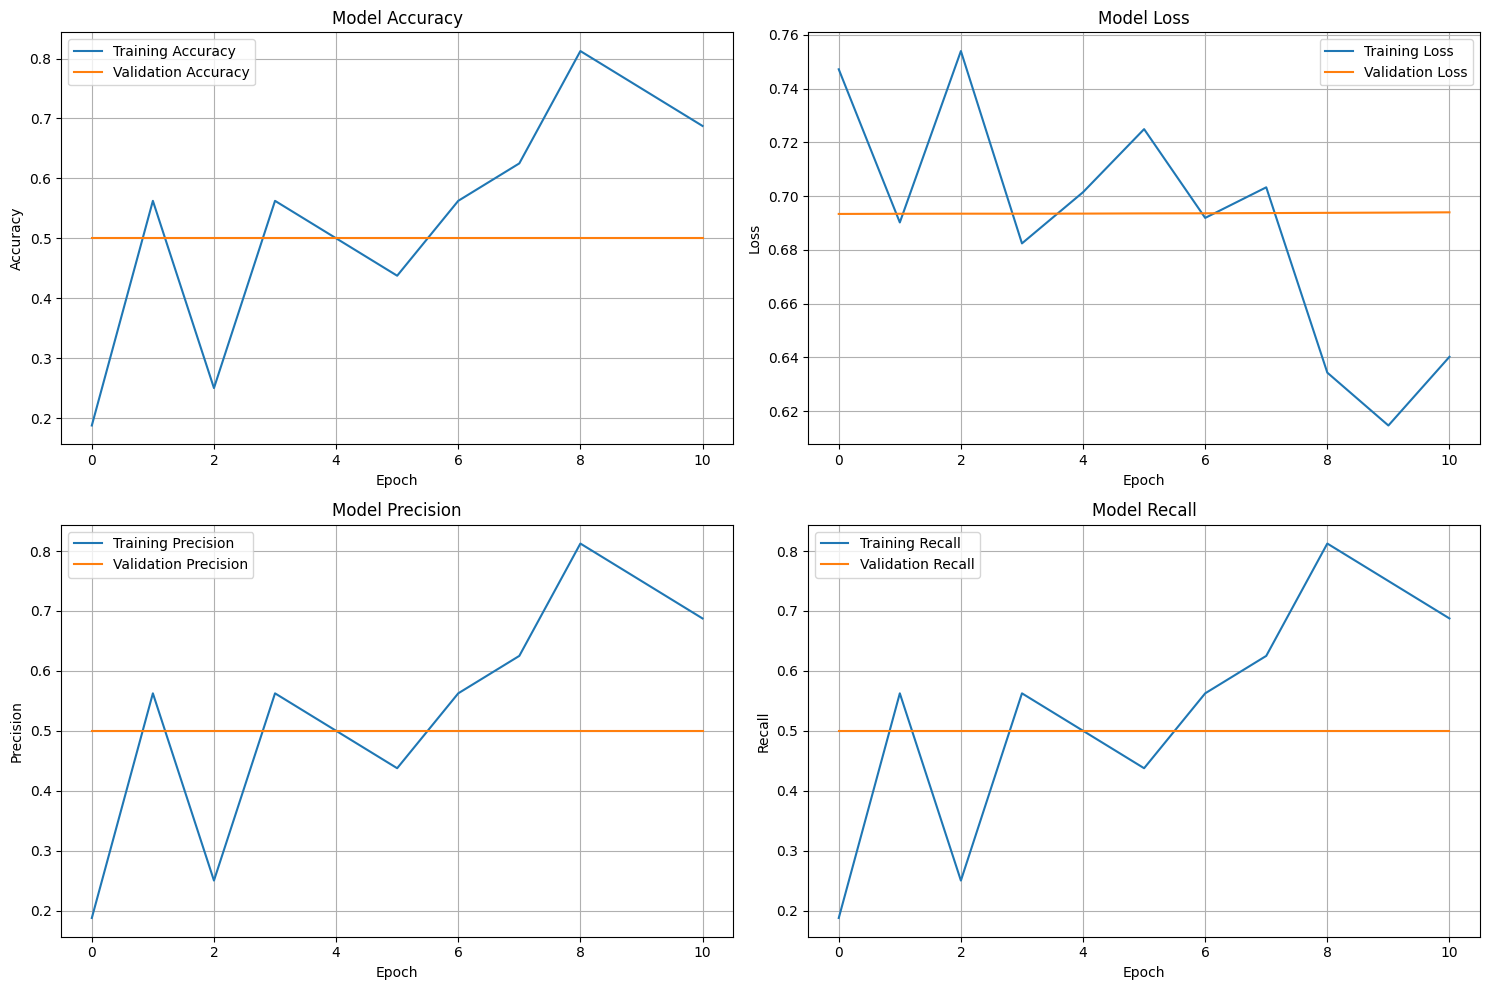


Evaluating model on test set...


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Test Set Metrics:
accuracy: 0.5000
precision: 0.5000
recall: 0.5000
f1_score: 0.5000
auc_score: 0.7600
loss: 0.6933
classification_report: {'Normal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5.0}, 'Glaucoma': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 5.0}, 'accuracy': 0.5, 'macro avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 10.0}, 'weighted avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 10.0}}
confusion_matrix: [[0, 5], [0, 5]]
predictions: [[0.49125799536705017, 0.5087419748306274], [0.491216242313385, 0.5087836980819702], [0.4912523627281189, 0.5087476372718811], [0.49121564626693726, 0.5087843537330627], [0.49120980501174927, 0.508790135383606], [0.49125155806541443, 0.508748471736908], [0.4912590980529785, 0.5087409615516663], [0.49126869440078735, 0.5087313055992126], [0.4912518262863159, 0.5087481737136841], [0.49

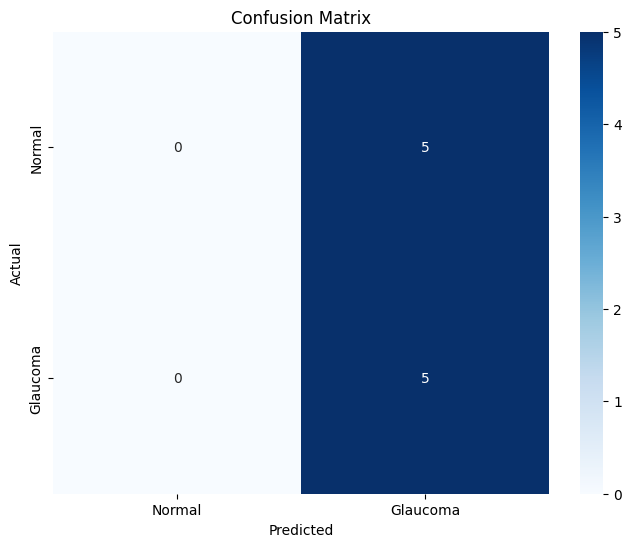


Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         5
    Glaucoma       0.50      1.00      0.67         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10



In [19]:
print("\n" + "="*60)
print("3. MODEL EVALUATION")
print("="*60)

# Plot training history
print("Creating training history visualization...")
model.plot_training_history(save_path='../static/training_history.png')

# Evaluate on test set
print("\nEvaluating model on test set...")
test_images_normalized = test_images / 255.0
metrics = model.evaluate(test_images_normalized, test_labels)

print("\nTest Set Metrics:")
for metric, value in metrics.items():
    if isinstance(value, (float, int)):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")

# Get predictions
predictions = model.model.predict(test_images_normalized)

# Ensure predicted_labels shape matches test_labels
if predictions.shape[-1] == 2:
    predicted_labels = np.argmax(predictions, axis=1)
else:
    predicted_labels = (predictions > 0.5).astype(int).flatten()

print("test_labels shape:", test_labels.shape)
print("predicted_labels shape:", predicted_labels.shape)

# Plot confusion matrix
print("\nCreating confusion matrix...")
model.plot_confusion_matrix(test_labels, predicted_labels, save_path='../static/confusion_matrix.png')

print("\nDetailed Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=['Normal', 'Glaucoma']))


In [ ]:
print("\n" + "="*60)
print("4. MODEL PERFORMANCE ANALYSIS")
print("="*60)

# Analyze prediction confidence distribution
print("Creating confidence analysis plots...")
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(predictions[test_labels == 0], bins=20, alpha=0.7, label='Normal', color='green')
plt.hist(predictions[test_labels == 1], bins=20, alpha=0.7, label='Glaucoma', color='red')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')
plt.legend()

plt.subplot(1, 2, 2)
confidence_scores = np.maximum(predictions.flatten(), 1 - predictions.flatten())
plt.hist(confidence_scores, bins=20, alpha=0.7, color='blue')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Model Confidence Distribution')

plt.tight_layout()
plt.savefig('../static/confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve and AUC
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('../static/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
print("\n" + "="*60)
print("5. FEATURE ANALYSIS AND INTERPRETABILITY")
print("="*60)

# Grad-CAM visualization for model interpretability
def generate_gradcam(model, img, class_index=1):
    """Generate Grad-CAM visualization"""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.layers[-2].output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, class_index]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Visualize attention maps for sample images
print("Creating attention maps...")
sample_indices = np.random.choice(len(test_images), 6, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    img = test_images[idx:idx+1] / 255.0
    true_label = test_labels[idx]
    pred_prob = predictions[idx][0]
    
    # Generate heatmap
    heatmap = generate_gradcam(model.model, img)
    
    # Resize heatmap to match image size
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (224, 224)).numpy().squeeze()
    
    plt.subplot(2, 3, i+1)
    plt.imshow(test_images[idx])
    plt.imshow(heatmap_resized, alpha=0.6, cmap='jet')
    plt.title(f'True: {true_label}, Pred: {pred_prob:.3f}')
    plt.axis('off')

plt.tight_layout()
plt.savefig('../static/attention_maps.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("\n" + "="*60)
print("6. MODEL DEPLOYMENT PREPARATION")
print("="*60)

# Save model with metadata
print("Saving model...")
model.save_model('../models/glaucoma_model.h5')

# Test prediction service
print("Testing prediction service...")
prediction_service = PredictionService('../models/glaucoma_model.h5')

# Test with sample image
sample_image = test_images[0]
result = prediction_service.predict_single(sample_image)

print("Sample Prediction Test:")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.3f}")
print(f"Status: {result['status']}")

# Performance summary
print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1-Score: {metrics['f1_score']:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("="*50)

# Save performance metrics
performance_summary = {
    'accuracy': float(metrics['accuracy']),
    'precision': float(metrics['precision']),
    'recall': float(metrics['recall']),
    'f1_score': float(metrics['f1_score']),
    'roc_auc': float(roc_auc),
    'training_samples': len(train_images),
    'validation_samples': len(X_val),
    'test_samples': len(test_images),
    'model_parameters': model.model.count_params(),
    'created_at': datetime.now().isoformat()
}

with open('../models/performance_summary.json', 'w') as f:
    json.dump(performance_summary, f, indent=4)

print("Performance summary saved to ../models/performance_summary.json")


In [ ]:
print("\n" + "="*60)
print("7. MODEL COMPARISON AND OPTIMIZATION")
print("="*60)

# Test different model architectures
model_types = ['custom', 'vgg16', 'resnet50']
results = {}

for model_type in model_types:
    print(f"\nTesting {model_type.upper()} model...")
    
    try:
        # Create model
        test_model = GlaucomaDetectionModel(
            input_shape=(224, 224, 3),
            model_type=model_type
        )
        test_model.create_model()
        test_model.compile_model()
        
        # Quick evaluation (small subset for speed)
        subset_size = min(100, len(test_images))
        subset_images = test_images[:subset_size] / 255.0
        subset_labels = test_labels[:subset_size]
        
        metrics = test_model.evaluate(subset_images, subset_labels)
        results[model_type] = metrics
        
        print(f"{model_type.upper()} - Accuracy: {metrics['accuracy']:.4f}")
        
    except Exception as e:
        print(f"Error with {model_type}: {str(e)}")
        results[model_type] = None

# Compare model performances
if len(results) > 1:
    print("\nCreating model comparison visualization...")
    plt.figure(figsize=(10, 6))
    
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] if results[name] else 0 for name in model_names]
    
    bars = plt.bar(model_names, accuracies, color=['#667eea', '#764ba2', '#f093fb'])
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('../static/model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("\n" + "="*60)
print("TRAINING AND EVALUATION COMPLETED!")
print("="*60)
print(f"Model saved to: ../models/glaucoma_model.h5")
print(f"Performance metrics saved to: ../models/performance_summary.json")
print(f"Visualizations saved to: ../static/")
print("\nNext steps:")
print("1. Start the web application: python src/app.py")
print("2. Access the dashboard at: http://localhost:8000")
print("3. Upload images for prediction")
print("4. Monitor model performance")
print("="*60) 